In [1]:
# --------------------------------------------------------
# MedSAM2 – Upper Airways
# Seed = Slice mit größter Maskenfläche (mehrere Boxes, ohne Padding)
# Speichert PNGs, Visualisierung und NIfTI – in ORIGINALER Ausrichtung
# --------------------------------------------------------
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from skimage import transform
from skimage.measure import label, regionprops
import torch
import gc
from tqdm import tqdm
import logging

# MedSAM2
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

# ---- Einstellungen ----
REORIENT_CANONICAL = False   # False = Original-Ausrichtung behalten (empfohlen für deine PNGs)
PAD_RATIO = 0.0              # 0.0 = kein Padding
OUT_NAME  = "segmentation_3d.nii.gz"

# ---- Logging ----
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# ---- Visual Helpers ----
def show_mask(mask, ax):
    color = np.array([251/255, 252/255, 30/255, 0.6])
    h, w = mask.shape[-2:]
    ax.imshow(mask.reshape(h, w, 1) * color.reshape(1, 1, -1))

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h   = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor="blue",
                               facecolor=(0,0,0,0), lw=2))

def vis_scale(img2d):
    p1, p99 = np.percentile(img2d, [1, 99])
    return np.clip((img2d - p1) / (p99 - p1 + 1e-8), 0, 1)

# ---- Boxes aus 2D-Maske (ohne Padding) ----
def get_bounding_boxes_from_mask(mask2d, H, W, pad_ratio=0.0):
    boxes = []
    lab = label(mask2d.astype(np.uint8))
    pad_x = max(1, int(pad_ratio * W))
    pad_y = max(1, int(pad_ratio * H))
    for r in regionprops(lab):
        minr, minc, maxr, maxc = r.bbox  # (row, col)
        x1 = max(0, minc - pad_x)
        y1 = max(0, minr - pad_y)
        x2 = min(W - 1, maxc + pad_x)
        y2 = min(H - 1, maxr + pad_y)
        boxes.append([x1, y1, x2, y2])   # [x_min, y_min, x_max, y_max]
    return boxes

# ---- Gerät & Modell ----
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logging.info(f"Verwende Gerät: {device}")

medsam_model = build_sam2(
    config_file="configs/sam2.1_hiera_t512.yaml",
    ckpt_path="checkpoints/MedSAM2_2411.pt",
    device=device
)
predictor = SAM2ImagePredictor(medsam_model)
logging.info("MedSAM2 model loaded successfully.")

# ---- Hauptfunktion ----
@torch.no_grad()
def process_upper_airways(images_dir, masks_dir, output_dir, resume_file=None, save_png=True):
    os.makedirs(output_dir, exist_ok=True)
    cases = sorted([f for f in os.listdir(masks_dir) if f.endswith(".nii") or f.endswith(".nii.gz")])

    # optional: Orientierungstools nur bei Bedarf importieren
    if REORIENT_CANONICAL:
        from nibabel.orientations import io_orientation, ornt_transform, apply_orientation

    resume = resume_file is None
    with tqdm(total=len(cases), desc="Fälle", unit="Fall") as pbar:
        for case in cases:
            if not resume and case == resume_file:
                resume = True
            if not resume:
                pbar.update(1); continue

            img_path  = os.path.join(images_dir, case)
            mask_path = os.path.join(masks_dir,  case)
            if not os.path.exists(img_path):
                logging.warning(f"Fehlendes Bild für Maske: {case}")
                pbar.update(1); continue

            # --- Load (optional canonical) ---
            nii_img_orig  = nib.load(img_path)
            nii_mask_orig = nib.load(mask_path)

            if REORIENT_CANONICAL:
                nii_img  = nib.as_closest_canonical(nii_img_orig)
                nii_mask = nib.as_closest_canonical(nii_mask_orig)
                # Transformationen merken (für Rückführung der PNGs falls gewünscht)
                ornt_orig = io_orientation(nii_img_orig.affine)
                ornt_can  = io_orientation(nii_img.affine)
                can2orig  = ornt_transform(ornt_can, ornt_orig)
            else:
                nii_img  = nii_img_orig
                nii_mask = nii_mask_orig
                can2orig = None  # nicht genutzt

            vol_img = nii_img.get_fdata()   # (H, W, Z) in gewählter Orientierung
            vol_msk = nii_mask.get_fdata()
            H, W, Z = vol_img.shape

            # --- Seed-Slice = größte Maskenfläche ---
            slice_areas = [np.sum(vol_msk[:, :, s] > 0) for s in range(Z)]
            seed_idx = int(np.argmax(slice_areas))
            if slice_areas[seed_idx] == 0:
                logging.warning(f"{case}: keine Maske in irgendeiner Slice → übersprungen.")
                pbar.update(1); continue
            logging.info(f"{case}: Seed-Slice (größte Fläche) = {seed_idx} (Area={slice_areas[seed_idx]:.0f})")

            # --- Boxes aus Seed holen ---
            seed_mask = (vol_msk[:, :, seed_idx] > 0).astype(np.uint8)
            boxes_xyxy = get_bounding_boxes_from_mask(seed_mask, H, W, pad_ratio=PAD_RATIO)
            if not boxes_xyxy:
                logging.warning(f"{case}: keine Bounding Boxes in Seed-Slice → übersprungen.")
                pbar.update(1); continue

            # --- Volumen → 1024 vorbereiten ---
            image_volume = []
            for z in range(Z):
                img = vol_img[:, :, z]
                img1024 = transform.resize(img, (1024, 1024), order=3,
                                           preserve_range=True, anti_aliasing=True)
                img1024 = (img1024 - img1024.min()) / (img1024.max() - img1024.min() + 1e-8)
                image_volume.append(np.stack([img1024]*3, axis=-1).astype(np.float32))
            image_volume = np.array(image_volume, dtype=np.float32)  # (Z,1024,1024,3)

            # --- Boxes in 1024-Koordinaten ---
            scale = np.array([W, H, W, H], dtype=np.float32)
            boxes1024 = []
            for (x1, y1, x2, y2) in boxes_xyxy:
                b = (np.array([x1, y1, x2, y2], dtype=np.float32) / scale) * 1024.0
                boxes1024.append(b[None, :])   # (1,4)

            # --- Segmentierung für alle Slices (gleiche Boxen) ---
            seg_3d = np.zeros((Z, 1024, 1024), dtype=np.uint8)
            for z in range(Z):
                predictor.set_image((image_volume[z] * 255).astype(np.uint8))
                combined = np.zeros((1024, 1024), dtype=np.uint8)
                for b in boxes1024:
                    seg = predictor.predict(box=b, multimask_output=False)[0]
                    seg = np.squeeze(seg).astype(np.uint8)
                    combined = np.maximum(combined, seg)
                seg_3d[z] = combined

            # --- Speichern ---
            case_out = os.path.join(output_dir, case.replace(".nii.gz","").replace(".nii",""))
            os.makedirs(case_out, exist_ok=True)

            # (A) PNG pro Slice – in der **aktuellen** Orientierung (bei dir: Original)
            if save_png:
                for z in range(Z):
                    plt.imsave(os.path.join(case_out, f"slice_{z}_segmentation.png"),
                               seg_3d[z], cmap="gray")

                # (B) Seed-Visualisierung
                vis_img = vis_scale(vol_img[:, :, seed_idx])
                vis_img = transform.resize(vis_img, (1024, 1024), order=1,
                                           preserve_range=True, anti_aliasing=False)
                vis_file = os.path.join(case_out, f"seed_slice_{seed_idx}_visualization.png")
                fig, ax = plt.subplots(1, 2, figsize=(12, 6))
                ax[0].imshow(vis_img, cmap="gray"); ax[0].set_aspect('equal')
                for b in boxes1024:
                    show_box(b[0], ax[0])
                ax[0].set_title(f"Seed-Slice {seed_idx} mit Bounding Boxes")
                ax[1].imshow(vis_img, cmap="gray"); ax[1].set_aspect('equal')
                show_mask(seg_3d[seed_idx], ax[1])
                ax[1].set_title("Segmentierung (Seed-Slice)")
                plt.savefig(vis_file, dpi=150, bbox_inches="tight"); plt.close(fig)

            # (C) NIfTI – gleiche Orientierung wie das verarbeitete NIfTI
            nib.save(nib.Nifti1Image(seg_3d.astype(np.uint8), affine=nii_img.affine),
                     os.path.join(case_out, OUT_NAME))

            # Cleanup
            del seg_3d, image_volume
            gc.collect()
            pbar.update(1)
            logging.info(f"Fertig: {case}")

# ---- Pfade (Upper Airways) ----
images_dir = r"F:\Rawan_Masterarbeit\data\upper_airways\filtered_images"
masks_dir  = r"F:\Rawan_Masterarbeit\data\upper_airways\filtered_masks"
output_dir = r"F:\Rawan_Masterarbeit\data\upper_airways\MedSAM2_results_seed_maxarea"
os.makedirs(output_dir, exist_ok=True)

process_upper_airways(
    images_dir=images_dir,
    masks_dir=masks_dir,
    output_dir=output_dir,
    resume_file="atm_029.nii.gz",   # oder None
    save_png=True
)


2025-08-16 21:41:02,704 - INFO - Verwende Gerät: cpu
2025-08-16 21:41:02,704 - INFO - Using device: cpu
2025-08-16 21:41:08,505 - INFO - Loaded checkpoint sucessfully
2025-08-16 21:41:09,444 - INFO - MedSAM2 model loaded successfully.
Fälle:   0%|                                                                                  | 0/32 [00:00<?, ?Fall/s]2025-08-16 21:41:11,925 - INFO - atm_029.nii.gz: Seed-Slice (größte Fläche) = 69 (Area=5047)
2025-08-16 21:41:28,684 - INFO - For numpy array image, we assume (HxWxC) format
2025-08-16 21:41:30,307 - INFO - Computing image embeddings for the provided image...
2025-08-16 21:41:33,001 - INFO - Image embeddings computed.
2025-08-16 21:41:33,906 - INFO - For numpy array image, we assume (HxWxC) format
2025-08-16 21:41:33,981 - INFO - Computing image embeddings for the provided image...
2025-08-16 21:41:35,061 - INFO - Image embeddings computed.
2025-08-16 21:41:35,427 - INFO - For numpy array image, we assume (HxWxC) format
2025-08-16 21:41:3

In [6]:
import os
import re
import csv
import numpy as np
import cv2
import logging
from collections import defaultdict
from tqdm import tqdm

# Pfade anpassen
gt_root   = r"F:\Rawan_Masterarbeit\data\upper_airways\filtered_masks_png"
pred_root = r"F:\Rawan_Masterarbeit\data\upper_airways\MedSAM2_results_seed_maxarea"

logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

# Regex für Dateinamen wie: atm_001_slice_0_Grund_truth_mask.png
PAT = re.compile(r"^(?P<case>atm_\d+)_slice_(?P<slice>\d+)_Grund_truth_mask\.png$", re.IGNORECASE)

def dice_score(a, b):
    a = (a > 0).astype(np.uint8)
    b = (b > 0).astype(np.uint8)
    inter = np.sum(a * b)
    tot = np.sum(a) + np.sum(b)
    return 1.0 if tot == 0 else (2.0 * inter) / tot

per_case_scores = defaultdict(list)
per_slice_rows = []  # optional: pro Slice loggen

files = [f for f in os.listdir(gt_root) if f.lower().endswith(".png")]
files.sort()

missing = 0
for fname in tqdm(files, desc="GT-Slices"):
    m = PAT.match(fname)
    if not m:
        logging.warning(f"Überspringe (passt nicht zum Muster): {fname}")
        continue

    case  = m.group("case")              # z.B. "atm_001"
    slice_idx = int(m.group("slice"))    # z.B. 0

    gt_path   = os.path.join(gt_root, fname)
    pred_path = os.path.join(pred_root, case, f"slice_{slice_idx}_segmentation.png")

    if not os.path.exists(pred_path):
        logging.warning(f"Prediction fehlt: {pred_path}")
        missing += 1
        continue

    gt   = cv2.imread(gt_path, cv2.IMREAD_GRAYSCALE)
    pred = cv2.imread(pred_path, cv2.IMREAD_GRAYSCALE)
    if gt is None or pred is None:
        logging.warning(f"Konnte Bild nicht lesen: {gt_path} oder {pred_path}")
        continue

    # Auf gleiche Größe bringen (Nearest für Labels)
    if gt.shape != pred.shape:
        pred = cv2.resize(pred, (gt.shape[1], gt.shape[0]), interpolation=cv2.INTER_NEAREST)

    d = dice_score(gt, pred)
    per_case_scores[case].append(d)
    per_slice_rows.append([case, slice_idx, float(d)])

# Zusammenfassen
case_rows = []
for case, scores in sorted(per_case_scores.items()):
    mean_case = float(np.mean(scores))
    case_rows.append([case, mean_case])
    logging.info(f"{case}: Mean Dice = {mean_case:.4f} (n={len(scores)})")

if case_rows:
    overall = float(np.mean([r[1] for r in case_rows]))
    print(f"\nFälle: {len(case_rows)} | Fehlende Predictions: {missing}")
    print(f"Gesamt-Mittelwert Dice: {overall:.4f}")

    # CSVs speichern
    out_case_csv  = os.path.join(pred_root, "dice_upper_airways_per_case.csv")
    out_slice_csv = os.path.join(pred_root, "dice_upper_airways_per_slice.csv")
    with open(out_case_csv, "w", newline="") as f:
        w = csv.writer(f); w.writerow(["case", "mean_dice"]); w.writerows(case_rows); w.writerow(["MEAN", overall])
    with open(out_slice_csv, "w", newline="") as f:
        w = csv.writer(f); w.writerow(["case", "slice", "dice"]); w.writerows(per_slice_rows)
    print(f"CSV (per case):  {out_case_csv}")
    print(f"CSV (per slice): {out_slice_csv}")
else:
    print("Keine übereinstimmenden Paare gefunden – prüfe Pfade/Dateinamen.")


GT-Slices: 100%|███████████████████████████████████████████████████████████████████| 2838/2838 [02:04<00:00, 22.84it/s]
2025-08-16 23:01:00,261 - INFO - atm_001: Mean Dice = 0.2350 (n=32)
2025-08-16 23:01:00,267 - INFO - atm_002: Mean Dice = 0.3092 (n=47)
2025-08-16 23:01:00,268 - INFO - atm_005: Mean Dice = 0.1223 (n=74)
2025-08-16 23:01:00,271 - INFO - atm_007: Mean Dice = 0.1486 (n=155)
2025-08-16 23:01:00,272 - INFO - atm_008: Mean Dice = 0.2363 (n=63)
2025-08-16 23:01:00,273 - INFO - atm_010: Mean Dice = 0.1110 (n=57)
2025-08-16 23:01:00,273 - INFO - atm_011: Mean Dice = 0.1083 (n=57)
2025-08-16 23:01:00,273 - INFO - atm_013: Mean Dice = 0.1212 (n=70)
2025-08-16 23:01:00,273 - INFO - atm_014: Mean Dice = 0.1318 (n=63)
2025-08-16 23:01:00,273 - INFO - atm_015: Mean Dice = 0.2475 (n=114)
2025-08-16 23:01:00,285 - INFO - atm_016: Mean Dice = 0.1202 (n=68)
2025-08-16 23:01:00,286 - INFO - atm_017: Mean Dice = 0.1189 (n=69)
2025-08-16 23:01:00,288 - INFO - atm_018: Mean Dice = 0.1096 (


Fälle: 32 | Fehlende Predictions: 0
Gesamt-Mittelwert Dice: 0.1446
CSV (per case):  F:\Rawan_Masterarbeit\data\upper_airways\MedSAM2_results_seed_maxarea\dice_upper_airways_per_case.csv
CSV (per slice): F:\Rawan_Masterarbeit\data\upper_airways\MedSAM2_results_seed_maxarea\dice_upper_airways_per_slice.csv


In [3]:
import os
import numpy as np
import cv2
import logging
import csv
from concurrent.futures import ThreadPoolExecutor

# Logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

# --- Pfade anpassen ---
gt_dir    = r"F:\Rawan_Masterarbeit\data\upper_airways\filtered_masks_png"
pred_root = r"F:\Rawan_Masterarbeit\data\upper_airways\MedSAM2_results_seed_maxarea"

# Dice
def dice_score(mask1, mask2):
    m1 = (mask1 > 0).astype(np.uint8)
    m2 = (mask2 > 0).astype(np.uint8)
    inter = np.sum(m1 * m2)
    total = np.sum(m1) + np.sum(m2)
    return 1.0 if total == 0 else (2.0 * inter) / total

# Einzeldatei verarbeiten (wie bei Spleen)
def process_single_file(gt_filename):
    # Beispiel: atm_001_slice_0_Grund_truth_mask.png
    try:
        parts = gt_filename.split("_slice_")
        case_name = parts[0]                 # "atm_001"
        slice_part = parts[1]                # "0_Grund_truth_mask.png"
        slice_num_str = slice_part.split("_")[0]  # "0"
        slice_num = int(slice_num_str)

        gt_path   = os.path.join(gt_dir, gt_filename)
        pred_path = os.path.join(pred_root, case_name, f"slice_{slice_num}_segmentation.png")

        if not os.path.exists(pred_path):
            logging.warning(f"Prediction nicht gefunden: {pred_path}")
            return None

        # Masken laden
        gt_mask   = cv2.imread(gt_path, cv2.IMREAD_GRAYSCALE)
        pred_mask = cv2.imread(pred_path, cv2.IMREAD_GRAYSCALE)
        if gt_mask is None or pred_mask is None:
            logging.warning(f"Konnte Datei nicht lesen: {gt_path} oder {pred_path}")
            return None

        # Prediction auf GT-Größe bringen
        if gt_mask.shape != pred_mask.shape:
            pred_mask = cv2.resize(pred_mask, (gt_mask.shape[1], gt_mask.shape[0]),
                                   interpolation=cv2.INTER_NEAREST)

        # Dice
        d = dice_score(gt_mask, pred_mask)
        logging.info(f"{case_name} slice {slice_num}: Dice = {d:.4f}")
        return f"{case_name}_slice_{slice_num}", d

    except Exception as e:
        logging.error(f"Fehler bei {gt_filename}: {e}")
        return None

# Parallel rechnen
gt_files = [f for f in os.listdir(gt_dir) if f.lower().endswith(".png")]
results = []
with ThreadPoolExecutor() as ex:
    futures = [ex.submit(process_single_file, f) for f in gt_files]
    for fut in futures:
        res = fut.result()
        if res is not None:
            results.append(res)

# Ergebnisse + CSV + Mittelwert
if results:
    out_csv = os.path.join(pred_root, "MedSAM2_dice_upper_airways_slices.csv")
    with open(out_csv, "w", newline="") as f:
        w = csv.writer(f)
        w.writerow(["Slice", "Dice"])
        w.writerows(results)

    mean_dice = float(np.mean([d for _, d in results]))
    logging.info(f"Anzahl Slices: {len(results)} | Durchschnittlicher Dice: {mean_dice:.4f}")
    logging.info(f"CSV gespeichert: {out_csv}")
else:
    logging.info("Keine Dice Scores berechnet – prüfe Pfade/Dateinamen.")


2025-08-18 16:59:15,479 - INFO - atm_001 slice 7: Dice = 0.0000
2025-08-18 16:59:15,482 - INFO - atm_001 slice 1: Dice = 0.0000
2025-08-18 16:59:15,482 - INFO - atm_001 slice 2: Dice = 0.0000
2025-08-18 16:59:15,482 - INFO - atm_001 slice 0: Dice = 0.0000
2025-08-18 16:59:15,608 - INFO - atm_001 slice 10: Dice = 0.0000
2025-08-18 16:59:15,616 - INFO - atm_001 slice 11: Dice = 0.0000
2025-08-18 16:59:15,633 - INFO - atm_001 slice 5: Dice = 0.0000
2025-08-18 16:59:15,657 - INFO - atm_001 slice 4: Dice = 0.0000
2025-08-18 16:59:15,716 - INFO - atm_001 slice 12: Dice = 0.2000
2025-08-18 16:59:15,724 - INFO - atm_001 slice 13: Dice = 0.3085
2025-08-18 16:59:15,756 - INFO - atm_001 slice 3: Dice = 0.0000
2025-08-18 16:59:15,783 - INFO - atm_001 slice 6: Dice = 0.0000
2025-08-18 16:59:15,831 - INFO - atm_001 slice 14: Dice = 0.0969
2025-08-18 16:59:15,832 - INFO - atm_001 slice 15: Dice = 0.0102
2025-08-18 16:59:15,870 - INFO - atm_001 slice 17: Dice = 0.4854
2025-08-18 16:59:15,877 - INFO - 

2025-08-18 17:00:14,410 - INFO - 
Durchschnittlicher Dice Score (Upper Airways): 0.1416


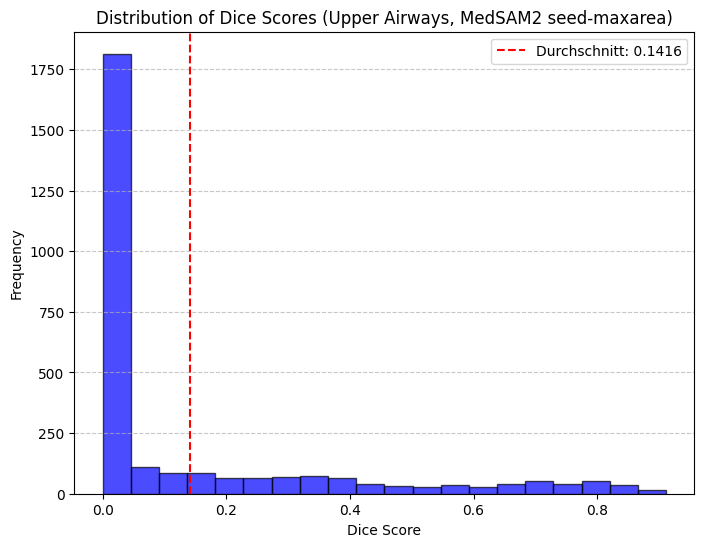

In [4]:
import matplotlib.pyplot as plt

# Ergebnisse + Visualisierung
if results:
    out_csv = os.path.join(pred_root, "MedSAM2_dice_upper_airways_slices.csv")
    with open(out_csv, "w", newline="") as file:
        writer = csv.writer(file)
        writer.writerow(["Slice", "Dice Score"])
        writer.writerows(results)

    # Dice-Werte extrahieren
    dice_values = [score for _, score in results]
    avg_dice = np.mean(dice_values)
    logging.info(f"\nDurchschnittlicher Dice Score (Upper Airways): {avg_dice:.4f}")

    # Histogramm
    plt.figure(figsize=(8, 6))
    plt.hist(dice_values, bins=20, color='blue', alpha=0.7, edgecolor='black')
    plt.title('Distribution of Dice Scores (Upper Airways, MedSAM2 seed-maxarea)')
    plt.xlabel('Dice Score')
    plt.ylabel('Frequency')
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Durchschnitt einzeichnen
    plt.axvline(avg_dice, color='red', linestyle='dashed', linewidth=1.5,
                label=f'Durchschnitt: {avg_dice:.4f}')
    plt.legend()

    # Plot speichern + anzeigen
    plt.savefig(os.path.join(pred_root, 'dice_score_histogram_MedSAM2_upper_airways_seed_maxarea.png'))
    plt.show()

else:
    logging.info("Keine Dice Scores berechnet!")


In [1]:
# --------------------------------------------------------
# MedSAM2 – Upper Airways mit Runtime-Messung
# Seed = Slice mit größter Maskenfläche (mehrere Boxes, ohne Padding)
# Speichert PNGs, Visualisierung und NIfTI – in ORIGINALER Ausrichtung
# Timing:
#   - Wall-Clock über Wrapper (akkumuliert, über Neustarts)
#   - Pro-Slice-Segmentierzeit (set_image + predict für alle Boxen) in timing_per_slice.csv
# --------------------------------------------------------
import os
import json
import time
import csv
import gc
import logging
from typing import Optional, List

import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from skimage import transform
from skimage.measure import label, regionprops
import torch
from tqdm import tqdm

# MedSAM2
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

# ---- Einstellungen ----
REORIENT_CANONICAL = False   # False = Original-Ausrichtung behalten (empfohlen für deine PNGs)
PAD_RATIO = 0.0              # 0.0 = kein Padding
OUT_NAME  = "segmentation_3d.nii.gz"

# ---- Logging ----
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# ---- Visual Helpers ----
def show_mask(mask, ax):
    color = np.array([251/255, 252/255, 30/255, 0.6])
    h, w = mask.shape[-2:]
    ax.imshow(mask.reshape(h, w, 1) * color.reshape(1, 1, -1))

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h   = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor="blue",
                               facecolor=(0,0,0,0), lw=2))

def vis_scale(img2d):
    p1, p99 = np.percentile(img2d, [1, 99])
    return np.clip((img2d - p1) / (p99 - p1 + 1e-8), 0, 1)

# ---- Boxes aus 2D-Maske (ohne/mit Padding) ----
def get_bounding_boxes_from_mask(mask2d: np.ndarray, H: int, W: int, pad_ratio: float = 0.0) -> List[List[int]]:
    boxes = []
    lab = label(mask2d.astype(np.uint8))
    pad_x = max(1, int(pad_ratio * W))
    pad_y = max(1, int(pad_ratio * H))
    for r in regionprops(lab):
        minr, minc, maxr, maxc = r.bbox  # (row, col)
        x1 = max(0, minc - pad_x)
        y1 = max(0, minr - pad_y)
        x2 = min(W - 1, maxc + pad_x)
        y2 = min(H - 1, maxr + pad_y)
        boxes.append([x1, y1, x2, y2])   # [x_min, y_min, x_max, y_max]
    return boxes

def get_largest_seed_slice(mask_vol: np.ndarray) -> Optional[int]:
    max_area, seed_idx = 0, None
    Z = mask_vol.shape[2]
    for s in range(Z):
        area = int(np.sum(mask_vol[:, :, s] > 0))
        if area > max_area:
            max_area, seed_idx = area, s
    return seed_idx

# ---- Runtime-Helpers ----
def _fmt(sec: float) -> str:
    h, r = divmod(sec, 3600)
    m, s = divmod(r, 60)
    return f"{int(h):02d}:{int(m):02d}:{s:05.2f}"

def _sum_seconds_from_csv(csv_path: str) -> float:
    if not os.path.exists(csv_path):
        return 0.0
    total = 0.0
    try:
        with open(csv_path, "r", encoding="utf-8") as f:
            reader = csv.DictReader(f)
            if not reader.fieldnames or "seconds" not in reader.fieldnames:
                return 0.0
            for row in reader:
                try:
                    total += float(row["seconds"])
                except Exception:
                    continue
    except Exception as e:
        logging.warning(f"Konnte CSV nicht auswerten ({csv_path}): {e}")
    return total

def _load_runtime_state(state_path: str) -> dict:
    if os.path.exists(state_path):
        try:
            with open(state_path, "r", encoding="utf-8") as f:
                return json.load(f)
        except Exception as e:
            logging.warning(f"Konnte Runtime-State nicht lesen: {e}")
    return {"sessions": [], "total_elapsed_sec": 0.0}

def _save_runtime_state(state_path: str, state: dict):
    with open(state_path, "w", encoding="utf-8") as f:
        json.dump(state, f, indent=2)

def time_run_accumulate(func, state_path: str, seed_timing_csv: str, *args, **kwargs):
    """
    Misst Wall-Clock des gesamten Laufs und akkumuliert in state_path.
    Loggt zusätzlich die Summe der Slice-Zeiten aus seed_timing_csv.
    """
    state = _load_runtime_state(state_path)
    start_perf = time.perf_counter()
    start_wall = time.time()
    logging.info("==== Starte Laufzeitmessung (akkumuliert) ====")
    try:
        return func(*args, **kwargs)
    finally:
        elapsed = time.perf_counter() - start_perf
        end_wall = time.time()

        state["sessions"].append({"start": start_wall, "end": end_wall, "elapsed_sec": elapsed})
        state["total_elapsed_sec"] = float(state.get("total_elapsed_sec", 0.0)) + float(elapsed)
        _save_runtime_state(state_path, state)

        msg1 = f"Aktueller Run: {_fmt(elapsed)} | Akkumuliert (Wall-Clock): {_fmt(state['total_elapsed_sec'])}"
        logging.info(msg1)

        total_csv_sec = _sum_seconds_from_csv(seed_timing_csv)
        msg2 = f"Akkumulierte Gesamtlaufzeit (aus CSV, alle Neustarts): {_fmt(total_csv_sec)}"
        logging.info(msg2)

        log_dir = os.path.dirname(seed_timing_csv) if seed_timing_csv else "."
        with open(os.path.join(log_dir, "runtime_log_medsam2_upper_airways.txt"), "a", encoding="utf-8") as f:
            f.write(msg1 + "\n")
            f.write(msg2 + "\n")

# ---- Gerät & Modell ----
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logging.info(f"Verwende Gerät: {device}")

medsam_model = build_sam2(
    config_file="configs/sam2.1_hiera_t512.yaml",
    # ckpt_path="checkpoints/MedSAM2_2411.pt",
    ckpt_path=r"F:\Rawan_Masterarbeit\MedSAM2_old\checkpoints\MedSAM2_2411.pt",
    device=device
)
predictor = SAM2ImagePredictor(medsam_model)
logging.info("MedSAM2 model loaded successfully.")

# ---- Hauptfunktion (mit Slice-Runtime in CSV) ----
@torch.no_grad()
def process_upper_airways(
    images_dir: str,
    masks_dir: str,
    output_dir: str,
    timing_csv: str,
    resume_file: Optional[str] = None,
    save_png: bool = True
):
    os.makedirs(output_dir, exist_ok=True)

    # CSV-Header (file, slice_idx, seconds)
    if not os.path.exists(timing_csv):
        with open(timing_csv, "w", newline="", encoding="utf-8") as fcsv:
            csv.writer(fcsv).writerow(["file", "slice_idx", "seconds"])

    cases = sorted([f for f in os.listdir(masks_dir) if f.endswith((".nii", ".nii.gz"))])

    # optional: Orientierungstools nur bei Bedarf importieren
    if REORIENT_CANONICAL:
        from nibabel.orientations import io_orientation, ornt_transform  # noqa: F401

    resume = resume_file is None
    with tqdm(total=len(cases), desc="Fälle", unit="Fall") as pbar:
        for case in cases:
            if not resume and case == resume_file:
                resume = True
            if not resume:
                pbar.update(1); continue

            img_path  = os.path.join(images_dir, case)
            mask_path = os.path.join(masks_dir,  case)
            if not os.path.exists(img_path):
                logging.warning(f"Fehlendes Bild für Maske: {case}")
                pbar.update(1); continue

            # --- Load (optional canonical) ---
            nii_img_orig  = nib.load(img_path)
            nii_mask_orig = nib.load(mask_path)

            if REORIENT_CANONICAL:
                nii_img  = nib.as_closest_canonical(nii_img_orig)
                nii_mask = nib.as_closest_canonical(nii_mask_orig)
            else:
                nii_img  = nii_img_orig
                nii_mask = nii_mask_orig

            vol_img = nii_img.get_fdata(dtype=np.float32)   # (H, W, Z)
            vol_msk = nii_mask.get_fdata(dtype=np.float32)
            H, W, Z = vol_img.shape

            # --- Seed-Slice = größte Maskenfläche ---
            slice_areas = [float(np.sum(vol_msk[:, :, s] > 0)) for s in range(Z)]
            seed_idx = int(np.argmax(slice_areas))
            if slice_areas[seed_idx] == 0:
                logging.warning(f"{case}: keine Maske in irgendeiner Slice → übersprungen.")
                pbar.update(1); continue
            logging.info(f"{case}: Seed-Slice (größte Fläche) = {seed_idx} (Area={slice_areas[seed_idx]:.0f})")

            # --- Boxes aus Seed holen ---
            seed_mask = (vol_msk[:, :, seed_idx] > 0).astype(np.uint8)
            boxes_xyxy = get_bounding_boxes_from_mask(seed_mask, H, W, pad_ratio=PAD_RATIO)
            if not boxes_xyxy:
                logging.warning(f"{case}: keine Bounding Boxes in Seed-Slice → übersprungen.")
                pbar.update(1); continue

            # --- Volumen → 1024 vorbereiten (Z,1024,1024,3) ---
            image_volume = []
            for z in range(Z):
                img = vol_img[:, :, z]
                img1024 = transform.resize(
                    img, (1024, 1024),
                    order=3, preserve_range=True, anti_aliasing=True
                )
                ptp = float(img1024.max() - img1024.min())
                img1024 = (img1024 - img1024.min()) / (ptp + 1e-8)
                image_volume.append(np.stack([img1024]*3, axis=-1).astype(np.float32))
            image_volume = np.asarray(image_volume, dtype=np.float32)

            # --- Boxes in 1024-Koordinaten ---
            scale = np.array([W, H, W, H], dtype=np.float32)
            boxes1024 = []
            for (x1, y1, x2, y2) in boxes_xyxy:
                b = (np.array([x1, y1, x2, y2], dtype=np.float32) / scale) * 1024.0
                boxes1024.append(b[None, :])   # (1,4)

            # --- Segmentierung für alle Slices (gleiche Boxen) ---
            seg_3d = np.zeros((Z, 1024, 1024), dtype=np.uint8)
            with tqdm(total=Z, desc=f"Slices in {case}", unit="Slice") as prog_slices:
                for z in range(Z):
                    t0 = time.perf_counter()
                    try:
                        predictor.set_image((image_volume[z] * 255).astype(np.uint8))
                        combined = np.zeros((1024, 1024), dtype=np.uint8)
                        for b in boxes1024:
                            masks, scores, logits = predictor.predict(
                                box=b.squeeze().tolist(),
                                multimask_output=False
                            )
                            seg = np.squeeze(masks[0]).astype(np.uint8)
                            combined = np.maximum(combined, seg)
                        seg_3d[z] = combined
                    except Exception as e:
                        logging.error(f"Fehler bei {case} Slice {z}: {e}")
                        seg_3d[z] = 0
                    finally:
                        elapsed_slice = time.perf_counter() - t0  # reine Segmentierung pro Slice
                        with open(timing_csv, "a", newline="", encoding="utf-8") as fcsv:
                            csv.writer(fcsv).writerow([case, z, f"{elapsed_slice:.4f}"])
                        prog_slices.update(1)

            # --- Speichern ---
            case_out = os.path.join(output_dir, case.replace(".nii.gz","").replace(".nii",""))
            os.makedirs(case_out, exist_ok=True)

            # (A) PNG pro Slice – in der aktuellen Orientierung (bei dir: Original)
            if save_png:
                for z in range(Z):
                    plt.imsave(os.path.join(case_out, f"slice_{z}_segmentation.png"),
                               seg_3d[z], cmap="gray")

                # (B) Seed-Visualisierung
                vis_img = vis_scale(vol_img[:, :, seed_idx])
                vis_img = transform.resize(
                    vis_img, (1024, 1024),
                    order=1, preserve_range=True, anti_aliasing=False
                )
                vis_file = os.path.join(case_out, f"seed_slice_{seed_idx}_visualization.png")
                fig, ax = plt.subplots(1, 2, figsize=(12, 6))
                ax[0].imshow(vis_img, cmap="gray"); ax[0].set_aspect('equal')
                for b in boxes1024:
                    show_box(b[0], ax[0])
                ax[0].set_title(f"Seed-Slice {seed_idx} mit Bounding Boxes")
                ax[1].imshow(vis_img, cmap="gray"); ax[1].set_aspect('equal')
                show_mask(seg_3d[seed_idx], ax[1])
                ax[1].set_title("Segmentierung (Seed-Slice)")
                for a in ax: a.axis('off')
                plt.savefig(vis_file, dpi=150, bbox_inches="tight"); plt.close(fig)

            # (C) NIfTI – gleiche Orientierung wie das verarbeitete NIfTI
            nib.save(nib.Nifti1Image(seg_3d.astype(np.uint8), affine=nii_img.affine),
                     os.path.join(case_out, OUT_NAME))

            # Cleanup
            del seg_3d, image_volume
            gc.collect()
            if device.type == "cuda":
                torch.cuda.empty_cache()
            pbar.update(1)
            logging.info(f"Fertig: {case}")

# ---- Pfade (Upper Airways) ----
if __name__ == "__main__":
    images_dir = r"F:\Rawan_Masterarbeit\data\upper_airways\filtered_images"
    masks_dir  = r"F:\Rawan_Masterarbeit\data\upper_airways\filtered_masks"
    output_dir = r"F:\Rawan_Masterarbeit\data\upper_airways\MedSAM2_results_seed_maxarea_with_run_time"
    os.makedirs(output_dir, exist_ok=True)

    timing_csv    = os.path.join(output_dir, "timing_per_slice.csv")
    runtime_state = os.path.join(output_dir, "runtime_state_upper_airways.json")

    # Lauf starten (Wall-Clock + CSV-Segmentierungszeit)
    time_run_accumulate(
        process_upper_airways,
        runtime_state,
        seed_timing_csv=timing_csv,
        images_dir=images_dir,
        masks_dir=masks_dir,
        output_dir=output_dir,
        timing_csv=timing_csv,   # hier landen die Slice-Zeiten
        resume_file=None,   # oder None
        save_png=True
    )

    # Optional: Gesamtsumme aus CSV separat loggen
    total_csv_sec = _sum_seconds_from_csv(timing_csv)
    logging.info(f"[FINAL] Gesamtlaufzeit aus CSV (alle Neustarts): {_fmt(total_csv_sec)}")


2025-09-14 23:34:14,787 - INFO - Verwende Gerät: cpu
2025-09-14 23:34:14,787 - INFO - Using device: cpu
2025-09-14 23:34:20,312 - INFO - Loaded checkpoint sucessfully
2025-09-14 23:34:21,039 - INFO - MedSAM2 model loaded successfully.
2025-09-14 23:34:21,112 - INFO - ==== Starte Laufzeitmessung (akkumuliert) ====
Fälle:   0%|                                                                                  | 0/31 [00:00<?, ?Fall/s]2025-09-14 23:34:22,141 - INFO - atm_001.nii.gz: Seed-Slice (größte Fläche) = 22 (Area=10919)

Slices in atm_001.nii.gz:   0%|                                                              | 0/32 [00:00<?, ?Slice/s]2025-09-14 23:34:26,043 - INFO - For numpy array image, we assume (HxWxC) format
2025-09-14 23:34:26,280 - INFO - Computing image embeddings for the provided image...
2025-09-14 23:34:27,509 - INFO - Image embeddings computed.

Slices in atm_001.nii.gz:   3%|█▋                                                    | 1/32 [00:01<00:54,  1.77s/Slice]2025-

In [5]:
import pandas as pd

# Pfad zur timing_per_slice.csv
csv_path = r"F:\Rawan_Masterarbeit\data\upper_airways\MedSAM2_results_seed_maxarea_with_run_time\timing_per_slice.csv"

# CSV laden
df = pd.read_csv(csv_path)

# Spalte seconds sicher als float laden
df['seconds'] = pd.to_numeric(df['seconds'], errors='coerce')

# Gesamtzeit
total_seconds = df['seconds'].sum()
total_minutes = total_seconds / 60
total_hours = total_seconds / 3600

# Anzahl der Slices
num_slices = len(df)

# Durchschnittszeit
avg_sec = df['seconds'].mean()
avg_min = avg_sec / 60

# Min/Max/Median
min_sec = df['seconds'].min()
max_sec = df['seconds'].max()
median_sec = df['seconds'].median()

# Ausgabe auf der Konsole
print("==== Timing Summary ====")
print(f"Slices verarbeitet : {num_slices}")
print(f"Gesamtzeit        : {total_seconds:.2f} Sekunden")
print(f"                   : {total_minutes:.2f} Minuten")
print(f"                   : {total_hours:.2f} Stunden")
print(f"Durchschnitt/Slice: {avg_sec:.2f} Sekunden ({avg_min:.2f} Minuten)")
print(f"Median/Slice      : {median_sec:.2f} Sekunden")
print(f"Schnellster Slice : {min_sec:.2f} Sekunden")
print(f"Langsamster Slice : {max_sec:.2f} Sekunden")

# Optional: Zusammenfassung in eine Textdatei speichern
summary_path = r"F:\Rawan_Masterarbeit\data\upper_airways\MedSAM2_results_seed_maxarea_with_run_time\timing_summary.txt"
with open(summary_path, "w") as f:
    f.write("==== Timing Summary ====\n")
    f.write(f"Slices verarbeitet : {num_slices}\n")
    f.write(f"Gesamtzeit        : {total_seconds:.2f} Sekunden\n")
    f.write(f"                   : {total_minutes:.2f} Minuten\n")
    f.write(f"                   : {total_hours:.2f} Stunden\n")
    f.write(f"Durchschnitt/Slice: {avg_sec:.2f} Sekunden ({avg_min:.2f} Minuten)\n")
    f.write(f"Median/Slice      : {median_sec:.2f} Sekunden\n")
    f.write(f"Schnellster Slice : {min_sec:.2f} Sekunden\n")
    f.write(f"Langsamster Slice : {max_sec:.2f} Sekunden\n")

print(f"\nZusammenfassung gespeichert in {summary_path}")


==== Timing Summary ====
Slices verarbeitet : 6767
Gesamtzeit        : 11974.47 Sekunden
                   : 199.57 Minuten
                   : 3.33 Stunden
Durchschnitt/Slice: 1.77 Sekunden (0.03 Minuten)
Median/Slice      : 1.76 Sekunden
Schnellster Slice : 0.96 Sekunden
Langsamster Slice : 12.03 Sekunden

Zusammenfassung gespeichert in F:\Rawan_Masterarbeit\data\upper_airways\MedSAM2_results_seed_maxarea_with_run_time\timing_summary.txt


In [1]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from skimage import transform
from skimage.measure import label, regionprops
import torch
import gc
from tqdm import tqdm
import logging

from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

# Logging aktivieren
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Maske anzeigen
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([251 / 255, 252 / 255, 30 / 255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

# Box anzeigen
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor="blue", facecolor=(0, 0, 0, 0), lw=2))

# Mehrere Bounding Boxes aus Maske extrahieren
def get_bounding_boxes_from_mask(mask):
    labeled_mask = label(mask)
    boxes = []
    for region in regionprops(labeled_mask):
        minr, minc, maxr, maxc = region.bbox
        boxes.append([minc, minr, maxc, maxr])  # [x_min, y_min, x_max, y_max]
    return boxes

# Inferenz mit MedSAM2 für eine einzelne Box
@torch.no_grad()
def medsam2_inference(predictor, image_rgb, box_1024):
    predictor.set_image((image_rgb * 255).astype(np.uint8))
    masks, scores, logits = predictor.predict(
        box=box_1024,
        multimask_output=False
    )
    return masks[0].astype(np.uint8)

# Gerät auswählen
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logging.info(f"Verwende Gerät: {device}")

# Modell laden
medsam_model = build_sam2(
    config_file="configs/sam2.1_hiera_t512.yaml",
    ckpt_path="checkpoints/MedSAM2_2411.pt",
    device=device
)
predictor = SAM2ImagePredictor(medsam_model)
logging.info("MedSAM2 model loaded successfully.")

# Segmentierung
def process_images_and_masks_with_resume(images_dir, masks_dir, output_dir, resume_file=None, resume_slice=None):
    resume = resume_file is None
    mask_files = sorted(os.listdir(masks_dir))

    with tqdm(total=len(mask_files), desc="Dateien", unit="Datei") as progress:
        for mask_file in mask_files:
            mask_path = os.path.join(masks_dir, mask_file)
            image_path = os.path.join(images_dir, mask_file)

            if not os.path.exists(image_path):
                logging.warning(f"Fehlendes Bild für Maske: {mask_file}")
                progress.update(1)
                continue

            if not resume and mask_file == resume_file:
                resume = True
            if not resume:
                progress.update(1)
                continue

            nifti_image = nib.load(image_path)
            nifti_mask = nib.load(mask_path)
            image_data = nifti_image.get_fdata()
            mask_data = nifti_mask.get_fdata()
            total_slices = image_data.shape[2]
            slice_start = resume_slice if mask_file == resume_file and resume_slice is not None else 0

            with tqdm(total=total_slices, desc=f"Slices in {mask_file}", unit="Slice") as slice_progress:
                for slice_idx in range(slice_start, total_slices):
                    logging.info(f"Verarbeite Slice {slice_idx} für Datei {mask_file}")
                    image_slice = image_data[:, :, slice_idx]
                    mask_slice = mask_data[:, :, slice_idx]

                    if np.sum(mask_slice) == 0:
                        slice_progress.update(1)
                        continue

                    boxes = get_bounding_boxes_from_mask(mask_slice)
                    H, W = image_slice.shape
                    resized_image = transform.resize(image_slice, (1024, 1024), order=3, preserve_range=True, anti_aliasing=True)
                    normalized_image = (resized_image - resized_image.min()) / max(resized_image.max() - resized_image.min(), 1e-8)
                    image_rgb = np.stack([normalized_image] * 3, axis=-1)

                    combined_seg = np.zeros((1024, 1024), dtype=np.uint8)

                    for box in boxes:
                        box_np = np.array(box)
                        box_1024 = box_np / np.array([W, H, W, H]) * 1024
                        seg = medsam2_inference(predictor, image_rgb, box_1024)
                        combined_seg = np.maximum(combined_seg, seg)

                    visualization_file = os.path.join(output_dir, f"{mask_file}_slice_{slice_idx}_visualization.png")
                    seg_file = os.path.join(output_dir, f"{mask_file}_slice_{slice_idx}_segmentation.png")

                    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
                    ax[0].imshow(resized_image, cmap="gray")
                    for box in boxes:
                        box_1024 = np.array(box) / np.array([W, H, W, H]) * 1024
                        show_box(box_1024, ax[0])
                    ax[0].set_title(f"Original Slice {slice_idx} mit Bounding Boxes")
                    ax[1].imshow(resized_image, cmap="gray")
                    show_mask(combined_seg, ax[1])
                    ax[1].set_title(f"Segmentierung Slice {slice_idx}")
                    plt.savefig(visualization_file)
                    plt.close(fig)

                    plt.imsave(seg_file, combined_seg, cmap="gray")
                    gc.collect()
                    slice_progress.update(1)

            logging.info(f"Fertig mit Datei {mask_file}")
            progress.update(1)



2025-07-05 11:26:17,078 - INFO - Verwende Gerät: cpu
2025-07-05 11:26:17,078 - INFO - Using device: cpu
2025-07-05 11:26:22,983 - INFO - Loaded checkpoint sucessfully
2025-07-05 11:26:23,828 - INFO - MedSAM2 model loaded successfully.


In [2]:

# Verzeichnisse definieren
images_dir = r"F:\Rawan_Masterarbeit\data\upper_airways\filtered_images"
masks_dir = r"F:\Rawan_Masterarbeit\data\upper_airways\filtered_masks"
output_dir = r"F:\Rawan_Masterarbeit\data\upper_airways\segmentation_results_medsam2"
os.makedirs(output_dir, exist_ok=True)

# Starten
process_images_and_masks_with_resume(
    images_dir=images_dir,
    masks_dir=masks_dir,
    output_dir=output_dir,
    resume_file="atm_037.nii.gz",
    resume_slice=20
)


Slices in atm_037.nii.gz:   0%|                                                              | 0/69 [00:00<?, ?Slice/s]2025-07-05 11:26:24,925 - INFO - Verarbeite Slice 20 für Datei atm_037.nii.gz
2025-07-05 11:26:25,250 - INFO - For numpy array image, we assume (HxWxC) format
2025-07-05 11:26:25,436 - INFO - Computing image embeddings for the provided image...
2025-07-05 11:26:26,623 - INFO - Image embeddings computed.

Slices in atm_037.nii.gz:   1%|▊                                                     | 1/69 [00:03<03:43,  3.29s/Slice]2025-07-05 11:26:28,233 - INFO - Verarbeite Slice 21 für Datei atm_037.nii.gz
2025-07-05 11:26:28,404 - INFO - For numpy array image, we assume (HxWxC) format
2025-07-05 11:26:28,468 - INFO - Computing image embeddings for the provided image...
2025-07-05 11:26:29,390 - INFO - Image embeddings computed.

Slices in atm_037.nii.gz:   3%|█▌                                                    | 2/69 [00:05<03:14,  2.91s/Slice]2025-07-05 11:26:30,864 - INFO 

In [3]:
# -*- coding: utf-8 -*-
import os
import json
import time
import csv
import gc
import logging
from typing import Optional, Tuple, List

import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from skimage import transform
from skimage.measure import label, regionprops
from tqdm import tqdm
import torch

# =============== MedSAM2 Imports ===============
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

# ========================= Logging =========================
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# =================== Visualisierungsfunktionen ===================
def show_mask(mask: np.ndarray, ax, random_color: bool = False):
    """
    Overlay einer Binärmaske (HxW) als RGBA (HxWx4). Wichtig: exakt 4 Kanäle!
    """
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([251/255, 252/255, 30/255, 0.6], dtype=np.float32)  # RGBA
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, 4)
    ax.imshow(mask_image)

def show_box(box: np.ndarray, ax):
    x0, y0, x1, y1 = float(box[0]), float(box[1]), float(box[2]), float(box[3])
    ax.add_patch(plt.Rectangle((x0, y0), x1 - x0, y1 - y0,
                               edgecolor="blue", facecolor=(0, 0, 0, 0), lw=2))

def get_bounding_boxes_from_mask(mask_2d: np.ndarray) -> List[List[int]]:
    """
    Liefert Liste von [x_min, y_min, x_max, y_max] für alle zusammenhängenden Komponenten (mask_2d != 0).
    """
    labeled_mask = label(mask_2d)
    boxes = []
    for region in regionprops(labeled_mask):
        minr, minc, maxr, maxc = region.bbox
        boxes.append([int(minc), int(minr), int(maxc), int(maxr)])
    return boxes

# =================== Gerät & Modell ===================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logging.info(f"Verwende Gerät: {device}")

medsam2_model = build_sam2(
    config_file="configs/sam2.1_hiera_t512.yaml",
    # ckpt_path=r"checkpoints/MedSAM2_2411.pt",   # <-- ggf. Pfad anpassen
    ckpt_path=r"F:\Rawan_Masterarbeit\MedSAM2_old\checkpoints\MedSAM2_2411.pt",
    device=device
)
predictor = SAM2ImagePredictor(medsam2_model)
logging.info("MedSAM2 Modell erfolgreich geladen.")

# =================== Helpers: Zeit/CSV/Runtime-State ===================
def _fmt(sec: float) -> str:
    h, r = divmod(sec, 3600)
    m, s = divmod(r, 60)
    return f"{int(h):02d}:{int(m):02d}:{s:05.2f}"

def _sum_seconds_from_csv(csv_path: str) -> float:
    if not os.path.exists(csv_path):
        return 0.0
    total = 0.0
    try:
        with open(csv_path, "r", encoding="utf-8") as f:
            reader = csv.DictReader(f)
            if not reader.fieldnames or "seconds" not in reader.fieldnames:
                return 0.0
            for row in reader:
                try:
                    total += float(row["seconds"])
                except Exception:
                    continue
    except Exception as e:
        logging.warning(f"Konnte CSV nicht auswerten ({csv_path}): {e}")
    return total

def _load_runtime_state(state_path: str) -> dict:
    if os.path.exists(state_path):
        try:
            with open(state_path, "r", encoding="utf-8") as f:
                return json.load(f)
        except Exception as e:
            logging.warning(f"Runtime-State nicht lesbar: {e}")
    return {"sessions": [], "total_elapsed_sec": 0.0}

def _save_runtime_state(state_path: str, state: dict):
    with open(state_path, "w", encoding="utf-8") as f:
        json.dump(state, f, indent=2)

def time_run_accumulate(func, state_path: str, seed_timing_csv: str, *args, **kwargs):
    """
    Führt func aus, misst Laufzeit des aktuellen Runs (Wall-Clock) und akkumuliert sie in state_path.
    Am Ende zusätzlich die akkumulierte Rechenzeit aus seed_timing_csv (CSV-Summe) loggen.
    """
    state = _load_runtime_state(state_path)
    start = time.perf_counter()
    start_wall = time.time()
    logging.info("==== Starte Laufzeitmessung (akkumuliert) ====")
    try:
        return func(*args, **kwargs)
    finally:
        elapsed = time.perf_counter() - start
        end_wall = time.time()
        state["sessions"].append({"start": start_wall, "end": end_wall, "elapsed_sec": elapsed})
        state["total_elapsed_sec"] = float(state.get("total_elapsed_sec", 0.0)) + float(elapsed)
        _save_runtime_state(state_path, state)

        msg1 = f"Aktueller Run: {_fmt(elapsed)} | Akkumuliert (Wall-Clock): {_fmt(state['total_elapsed_sec'])}"
        logging.info(msg1)
        total_csv_sec = _sum_seconds_from_csv(seed_timing_csv)
        msg2 = f"Akkumulierte Gesamtlaufzeit (aus CSV, alle Neustarts): {_fmt(total_csv_sec)}"
        logging.info(msg2)
        with open("runtime_log_medsam2_upper_airways.txt", "a", encoding="utf-8") as f:
            f.write(msg1 + "\n")
            f.write(msg2 + "\n")

# =================== Resume-Checkpoint ===================
def save_resume_state(checkpoint_path: str, filename: str, slice_idx: int):
    state = {"resume_file": filename, "resume_slice": slice_idx}
    with open(checkpoint_path, "w", encoding="utf-8") as f:
        json.dump(state, f)

def load_resume_state(checkpoint_path: str) -> Tuple[Optional[str], Optional[int]]:
    if os.path.exists(checkpoint_path):
        try:
            with open(checkpoint_path, "r", encoding="utf-8") as f:
                state = json.load(f)
            return state.get("resume_file"), state.get("resume_slice")
        except Exception as e:
            logging.warning(f"Checkpoint nicht lesbar: {e}")
    return None, None

# =================== Inferenz (SAM2) ===================
@torch.no_grad()
def medsam2_predict_for_boxes(
    predictor: SAM2ImagePredictor,
    image_rgb_u8: np.ndarray,
    boxes_1024: np.ndarray
) -> np.ndarray:
    """
    Setzt das Bild EINMAL und inferiert für mehrere Boxen.
    image_rgb_u8: (1024,1024,3) uint8
    boxes_1024:   (N,4) float32 in 1024-Koordinaten [x0,y0,x1,y1]
    """
    predictor.set_image(image_rgb_u8)
    combined = np.zeros((image_rgb_u8.shape[0], image_rgb_u8.shape[1]), dtype=np.uint8)
    for b in boxes_1024:
        masks, scores, logits = predictor.predict(box=b.tolist(), multimask_output=False)
        combined = np.maximum(combined, masks[0].astype(np.uint8))
    return combined

# =================== Pipeline (Upper Airways) ===================
def process_images_and_masks_with_resume(
    images_dir: str,
    masks_dir: str,
    output_dir: str,
    checkpoint_path: str,
    timing_csv: str,
    resume_file: Optional[str] = None,
    resume_slice: Optional[int] = None,
    use_auto_resume: bool = True,
):
    """
    - Segmentiert alle Upper-Airways-Volumes sliceweise mit MedSAM2 (Multi-BBox aus GT).
    - Schreibt VOR JEDEM Slice einen Resume-Checkpoint.
    - Hängt pro Slice die Laufzeit an timing_csv an (persistiert über Neustarts).
    """
    os.makedirs(output_dir, exist_ok=True)

    # Auto-Resume
    if use_auto_resume and (resume_file is None and resume_slice is None):
        cf, cs = load_resume_state(checkpoint_path)
        if cf is not None:
            logging.info(f"Automatischer Resume → Datei={cf}, Slice={cs}")
            resume_file, resume_slice = cf, cs

    # timing CSV initialisieren (Header nur einmal)
    if not os.path.exists(timing_csv):
        with open(timing_csv, "w", newline="", encoding="utf-8") as fcsv:
            csv.writer(fcsv).writerow(["file", "slice_idx", "seconds"])

    # Dateiliste (über Masken; Bildnamen identisch erwartet)
    mask_files = sorted([f for f in os.listdir(masks_dir) if f.endswith((".nii", ".nii.gz"))])
    resume_armed = resume_file is None  # erst ab resume_file loslegen

    with tqdm(total=len(mask_files), desc="Dateien", unit="Datei") as prog_files:
        for mask_file in mask_files:
            mask_path = os.path.join(masks_dir, mask_file)
            image_path = os.path.join(images_dir, mask_file)

            if not os.path.exists(image_path):
                logging.warning(f"Fehlendes Bild für Maske: {mask_file}")
                prog_files.update(1)
                continue

            if not resume_armed:
                if mask_file == resume_file:
                    resume_armed = True
                else:
                    prog_files.update(1)
                    continue

            # NIfTI laden
            nifti_image = nib.load(image_path)
            nifti_mask  = nib.load(mask_path)
            image_data = nifti_image.get_fdata()
            mask_data  = nifti_mask.get_fdata()

            if image_data.ndim != 3:
                raise ValueError(f"Erwartet 3D (H×W×S), erhalten shape={image_data.shape} für {mask_file}")

            total_slices = image_data.shape[2]
            slice_start = resume_slice if (mask_file == resume_file and resume_slice is not None) else 0

            with tqdm(total=total_slices, desc=f"Slices in {mask_file}", unit="Slice") as prog_slices:
                for slice_idx in range(slice_start, total_slices):
                    t0 = time.perf_counter()
                    fig = None
                    try:
                        # Checkpoint vor Bearbeitung
                        save_resume_state(checkpoint_path, mask_file, slice_idx)

                        image_slice = image_data[:, :, slice_idx]
                        mask_slice  = mask_data[:, :, slice_idx]

                        # Zeit trotzdem loggen, auch wenn leer
                        if np.sum(mask_slice) == 0:
                            elapsed_slice = time.perf_counter() - t0
                            with open(timing_csv, "a", newline="", encoding="utf-8") as fcsv:
                                csv.writer(fcsv).writerow([mask_file, slice_idx, f"{elapsed_slice:.4f}"])
                            prog_slices.update(1)
                            continue

                        # Multi-Box aus GT
                        boxes = get_bounding_boxes_from_mask(mask_slice)
                        H, W = image_slice.shape

                        # Preprocessing
                        resized_image = transform.resize(
                            image_slice, (1024, 1024), order=3, preserve_range=True, anti_aliasing=True
                        )
                        ptp = float(resized_image.max() - resized_image.min())
                        normalized_image = (resized_image - resized_image.min()) / max(ptp, 1e-8)
                        image_rgb_u8 = (np.stack([normalized_image]*3, axis=-1) * 255).astype(np.uint8)

                        # Boxen auf 1024 skalieren
                        boxes_np = np.array(boxes, dtype=np.float32)
                        boxes_1024 = boxes_np / np.array([W, H, W, H], dtype=np.float32) * 1024.0

                        # Inferenz
                        combined_seg = medsam2_predict_for_boxes(predictor, image_rgb_u8, boxes_1024)

                        # Speichern (Visualisierung + Maske)
                        vis_file = os.path.join(output_dir, f"{mask_file}_slice_{slice_idx}_visualization.png")
                        seg_file = os.path.join(output_dir, f"{mask_file}_slice_{slice_idx}_segmentation.png")

                        try:
                            fig, ax = plt.subplots(1, 2, figsize=(12, 6))
                            ax[0].imshow(resized_image, cmap="gray")
                            for b in boxes_1024:
                                show_box(b, ax[0])
                            ax[0].set_title(f"Original Slice {slice_idx} mit Bounding Boxes")

                            ax[1].imshow(resized_image, cmap="gray")
                            show_mask(combined_seg, ax[1])
                            ax[1].set_title(f"Segmentierung Slice {slice_idx}")

                            plt.savefig(vis_file)
                            plt.imsave(seg_file, combined_seg, cmap="gray")
                        finally:
                            if fig is not None:
                                plt.close(fig)

                    except Exception as e:
                        logging.error(f"Fehler bei {mask_file} Slice {slice_idx}: {e}")
                    finally:
                        # Slice-Zeit anhängen (persistiert über alle Runs)
                        elapsed_slice = time.perf_counter() - t0
                        with open(timing_csv, "a", newline="", encoding="utf-8") as fcsv:
                            csv.writer(fcsv).writerow([mask_file, slice_idx, f"{elapsed_slice:.4f}"])

                        # Cleanup
                        gc.collect()
                        if device.type == "cuda":
                            torch.cuda.empty_cache()

                        prog_slices.update(1)

            logging.info(f"Fertig mit Datei {mask_file}")
            prog_files.update(1)

    # Fertig → Checkpoint löschen
    if os.path.exists(checkpoint_path):
        os.remove(checkpoint_path)
        logging.info("Checkpoint entfernt (Pipeline abgeschlossen).")

# =================== AUSFÜHRUNG (Upper Airways) ===================
if __name__ == "__main__":
    # Verzeichnisse definieren (anpassen)
    images_dir = r"F:\Rawan_Masterarbeit\data\upper_airways\filtered_images"
    masks_dir  = r"F:\Rawan_Masterarbeit\data\upper_airways\filtered_masks"
    output_dir = r"F:\Rawan_Masterarbeit\data\upper_airways\MedSAM2_results_with_run_time"
    os.makedirs(output_dir, exist_ok=True)

    checkpoint_path = os.path.join(output_dir, "resume_checkpoint.json")
    timing_csv      = os.path.join(output_dir, "timing_per_slice.csv")
    runtime_state   = os.path.join(output_dir, "runtime_state.json")

    # Manuelles Resume (optional). Wenn None/None → Auto-Resume via JSON.
    manual_resume_file  = "atm_037.nii.gz"   # z.B. Datei oder None
    manual_resume_slice = 20                 # z.B. 0 oder None

    # Lauf starten (Wall-Clock akkumuliert + CSV-basierte Gesamtzeit)
    time_run_accumulate(
        process_images_and_masks_with_resume,
        runtime_state,              # state_path
        seed_timing_csv=timing_csv, # Für die CSV-Summe am Ende
        images_dir=images_dir,
        masks_dir=masks_dir,
        output_dir=output_dir,
        checkpoint_path=checkpoint_path,
        timing_csv=timing_csv,      # Pflichtargument für die Pipeline
        resume_file=manual_resume_file,
        resume_slice=manual_resume_slice,
        use_auto_resume=True,
    )

    # Optional: CSV-Gesamtzeit explizit loggen
    total_csv_sec = _sum_seconds_from_csv(timing_csv)
    logging.info(f"[FINAL] Gesamtlaufzeit (CSV über alle Neustarts): {_fmt(total_csv_sec)}")


2025-09-10 14:14:59,592 - INFO - Verwende Gerät: cpu
2025-09-10 14:14:59,594 - INFO - Using device: cpu
2025-09-10 14:15:05,557 - INFO - Loaded checkpoint sucessfully
2025-09-10 14:15:06,564 - INFO - MedSAM2 Modell erfolgreich geladen.
2025-09-10 14:15:06,598 - INFO - ==== Starte Laufzeitmessung (akkumuliert) ====
Slices in atm_037.nii.gz:   0%|                                                              | 0/69 [00:00<?, ?Slice/s]2025-09-10 14:15:08,670 - INFO - For numpy array image, we assume (HxWxC) format
2025-09-10 14:15:09,286 - INFO - Computing image embeddings for the provided image...
2025-09-10 14:15:11,475 - INFO - Image embeddings computed.

Slices in atm_037.nii.gz:   1%|▊                                                     | 1/69 [00:05<06:35,  5.81s/Slice]2025-09-10 14:15:14,117 - INFO - For numpy array image, we assume (HxWxC) format
2025-09-10 14:15:14,180 - INFO - Computing image embeddings for the provided image...
2025-09-10 14:15:15,343 - INFO - Image embeddings c

In [4]:
import pandas as pd

# Pfad zur timing_per_slice.csv
csv_path = r"F:\Rawan_Masterarbeit\data\upper_airways\MedSAM2_results_with_run_time\timing_per_slice.csv"

# CSV laden
df = pd.read_csv(csv_path)

# Spalte seconds sicher als float laden
df['seconds'] = pd.to_numeric(df['seconds'], errors='coerce')

# Gesamtzeit
total_seconds = df['seconds'].sum()
total_minutes = total_seconds / 60
total_hours = total_seconds / 3600

# Anzahl der Slices
num_slices = len(df)

# Durchschnittszeit
avg_sec = df['seconds'].mean()
avg_min = avg_sec / 60

# Min/Max/Median
min_sec = df['seconds'].min()
max_sec = df['seconds'].max()
median_sec = df['seconds'].median()

# Ausgabe auf der Konsole
print("==== Timing Summary ====")
print(f"Slices verarbeitet : {num_slices}")
print(f"Gesamtzeit        : {total_seconds:.2f} Sekunden")
print(f"                   : {total_minutes:.2f} Minuten")
print(f"                   : {total_hours:.2f} Stunden")
print(f"Durchschnitt/Slice: {avg_sec:.2f} Sekunden ({avg_min:.2f} Minuten)")
print(f"Median/Slice      : {median_sec:.2f} Sekunden")
print(f"Schnellster Slice : {min_sec:.2f} Sekunden")
print(f"Langsamster Slice : {max_sec:.2f} Sekunden")

# Optional: Zusammenfassung in eine Textdatei speichern
summary_path = "data/upper_airways/MedSAM2_results_with_run_time/timing_summary.txt"
with open(summary_path, "w") as f:
    f.write("==== Timing Summary ====\n")
    f.write(f"Slices verarbeitet : {num_slices}\n")
    f.write(f"Gesamtzeit        : {total_seconds:.2f} Sekunden\n")
    f.write(f"                   : {total_minutes:.2f} Minuten\n")
    f.write(f"                   : {total_hours:.2f} Stunden\n")
    f.write(f"Durchschnitt/Slice: {avg_sec:.2f} Sekunden ({avg_min:.2f} Minuten)\n")
    f.write(f"Median/Slice      : {median_sec:.2f} Sekunden\n")
    f.write(f"Schnellster Slice : {min_sec:.2f} Sekunden\n")
    f.write(f"Langsamster Slice : {max_sec:.2f} Sekunden\n")

print(f"\nZusammenfassung gespeichert in {summary_path}")


==== Timing Summary ====
Slices verarbeitet : 6325
Gesamtzeit        : 18716.82 Sekunden
                   : 311.95 Minuten
                   : 5.20 Stunden
Durchschnitt/Slice: 2.96 Sekunden (0.05 Minuten)
Median/Slice      : 2.62 Sekunden
Schnellster Slice : 0.01 Sekunden
Langsamster Slice : 2189.42 Sekunden


FileNotFoundError: [Errno 2] No such file or directory: 'data/upper_airways/MedSAM2_results_with_run_time/timing_summary.txt'

In [1]:
import os
import numpy as np
import cv2
import logging
import csv
from concurrent.futures import ThreadPoolExecutor

# Logging konfigurieren
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

# Ordner mit den Masken und Segmentierungen
mask_png_folder = r"F:\Rawan_Masterarbeit\data\upper_airways\filtered_masks_png"
segmentation_results_folder = r"F:\Rawan_Masterarbeit\data\upper_airways\segmentation_results_medsam2"

# Funktion zur Berechnung des Dice Scores
def dice_score(mask1, mask2):
    intersection = np.sum(mask1 * mask2)
    if np.sum(mask1) + np.sum(mask2) == 0:
        return 1.0  # Sonderfall: Beide Masken sind komplett leer
    dice = (2. * intersection) / (np.sum(mask1) + np.sum(mask2))
    return dice

# Funktion zur Verarbeitung einer einzelnen Datei
def process_single_file(mask_filename):
    base_name = mask_filename.split("_slice_")[0]
    slice_number = mask_filename.split("_slice_")[-1].split("_")[0]
    
    # Slice-Index nicht konvertieren, um den Slice korrekt zu matchen
    # Segmentierungsdatei hat den Format: atm_001.nii.gz_slice_0_segmentation
    segmentation_filename = f"{base_name}.nii.gz_slice_{slice_number}_segmentation.png"
    # Grundtruth-Maske hat den Format: atm_001_slice_0_Grund_truth_mask
    ground_truth_filename = f"{base_name}_slice_{slice_number}_Grund_truth_mask.png"

    # Pfade für Segmentierung und Grundtruth-Maske
    mask_png_path = os.path.join(mask_png_folder, mask_filename)
    segmentation_path = os.path.join(segmentation_results_folder, segmentation_filename)
    ground_truth_path = os.path.join(mask_png_folder, ground_truth_filename)

    if os.path.exists(segmentation_path) and os.path.exists(ground_truth_path):
        try:
            # Masken laden
            mask_png = cv2.imread(mask_png_path, cv2.IMREAD_GRAYSCALE)
            segmentation = cv2.imread(segmentation_path, cv2.IMREAD_GRAYSCALE)
            ground_truth = cv2.imread(ground_truth_path, cv2.IMREAD_GRAYSCALE)

            # Sicherstellen, dass alle Masken binär sind (0 und 1)
            mask_png = (mask_png > 0).astype(np.uint8)
            segmentation = (segmentation > 0).astype(np.uint8)
            ground_truth = (ground_truth > 0).astype(np.uint8)

            # Dice Score berechnen (zwischen Segmentierung und Grundtruth)
            dice_segmentation_gt = dice_score(segmentation, ground_truth)
            logging.info(f"{mask_filename}: Dice Score zwischen Segmentierung und Grundtruth = {dice_segmentation_gt:.4f}")
            
            return mask_filename, dice_segmentation_gt
        except Exception as e:
            logging.error(f"Fehler beim Verarbeiten von {mask_filename}: {e}")
            return None
    else:
        logging.warning(f"Segmentationsdatei oder Grundtruth-Maske für {mask_filename} nicht gefunden!")
        return None

# Parallelisierte Verarbeitung
dice_scores = []
with ThreadPoolExecutor() as executor:
    futures = [executor.submit(process_single_file, mask_filename) for mask_filename in os.listdir(mask_png_folder) if mask_filename.endswith(".png")]
    dice_scores = [future.result() for future in futures if future.result() is not None]

# Ergebnisse in eine CSV-Datei speichern
with open('dice_scores.csv', 'w', newline='') as csvfile:
    fieldnames = ['Mask Filename', 'Dice Score']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    for filename, score in dice_scores:
        writer.writerow({'Mask Filename': filename, 'Dice Score': score})

logging.info("Berechnung abgeschlossen. Dice Scores wurden in 'dice_scores.csv' gespeichert.")


2025-08-18 15:19:25,345 - INFO - atm_001_slice_1_Grund_truth_mask.png: Dice Score zwischen Segmentierung und Grundtruth = 0.9432
2025-08-18 15:19:25,345 - INFO - atm_001_slice_3_Grund_truth_mask.png: Dice Score zwischen Segmentierung und Grundtruth = 0.9279
2025-08-18 15:19:25,361 - INFO - atm_001_slice_5_Grund_truth_mask.png: Dice Score zwischen Segmentierung und Grundtruth = 0.9488
2025-08-18 15:19:25,361 - INFO - atm_001_slice_6_Grund_truth_mask.png: Dice Score zwischen Segmentierung und Grundtruth = 0.9181
2025-08-18 15:19:25,427 - INFO - atm_001_slice_0_Grund_truth_mask.png: Dice Score zwischen Segmentierung und Grundtruth = 0.9106
2025-08-18 15:19:25,361 - INFO - atm_001_slice_7_Grund_truth_mask.png: Dice Score zwischen Segmentierung und Grundtruth = 0.9072
2025-08-18 15:19:25,498 - INFO - atm_001_slice_8_Grund_truth_mask.png: Dice Score zwischen Segmentierung und Grundtruth = 0.8351
2025-08-18 15:19:25,517 - INFO - atm_001_slice_9_Grund_truth_mask.png: Dice Score zwischen Segmen

2025-08-18 15:20:43,754 - INFO - 
Durchschnittlicher Dice Score: 0.8269


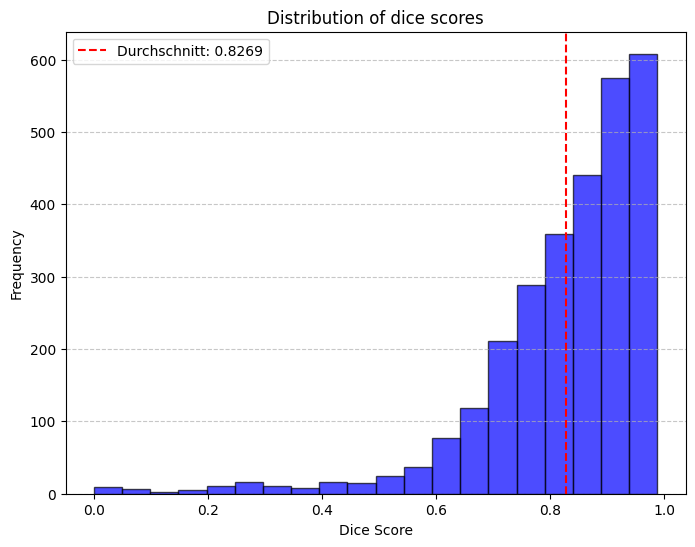

In [2]:
import matplotlib.pyplot as plt

# Ergebnisse speichern und analysieren
if dice_scores:
    # Ergebnisse in CSV speichern
    with open("F:\\Rawan_Masterarbeit\\data\\upper_airways\\dice_scores_Medsam2.csv", "w", newline="") as file:
        writer = csv.writer(file)
        writer.writerow(["Maskenname", "Dice Score"])
        writer.writerows(dice_scores)

    # Durchschnitt berechnen
    dice_values = [score for _, score in dice_scores]
    avg_dice = np.mean(dice_values)
    logging.info(f"\nDurchschnittlicher Dice Score: {avg_dice:.4f}")

    # Histogramm erstellen
    plt.figure(figsize=(8, 6))
    plt.hist(dice_values, bins=20, color='blue', alpha=0.7, edgecolor='black')
    plt.title('Distribution of dice scores')
    plt.xlabel('Dice Score')
    plt.ylabel('Frequency')
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Durchschnitt im Histogramm markieren
    plt.axvline(avg_dice, color='red', linestyle='dashed', linewidth=1.5, label=f'Durchschnitt: {avg_dice:.4f}')
    plt.legend()

    # Plot speichern und anzeigen
    plt.savefig('F:\\Rawan_Masterarbeit\\data\\upper_airways\\dice_score_histogram_Medsam2.png')
    plt.show()
else:
    logging.info("Keine Dice Scores berechnet!")
